In [1]:
from build.thermal_conduction import ThermalConduction
from rom.pod import POD
import os
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
import torch
import random
from tqdm import tqdm
import time
from lightning.pytorch import seed_everything
from rom.model.pod_nn import PODNN
from rom.model.pod_dl_rom import POD_DL_ROM
from rom.model.dl_rom import DLROM
from rom.model.interpolation_network import InterpolationNetwork
from rom.model.fno import FNO2d
from rom.normalization import Normalizer, NormalizerParameters

seed_everything(1999, workers=True)

Seed set to 1999


1999

# POD on thermal problem

This notebook contains the report for the exam in Advanced Reduced Order Methods in Scientific Machine Learning. The goal of this project is to extend the work done in the Computational Mechanics with ROMs exam project. Specifically, in the previous notebook we have successfully solved two different problems in the reduced order modeling context. However, we have also observed that the third and most challenging problem cannot be solved efficiently using standard ROM techniques. In this work, we will explore advanced ROM strategies based on machine learning models to address this third scenario. The following section briefly introduces the problem.

## Problem formulation

The heat equation considered throughout this work is:

$$
\begin{cases}
k \Delta u = 0 & \text{in } \Omega, \\
u = 0 & \text{on } \partial \Omega_1 \cup \partial \Omega_2, \\
u = T_{bc} & \text{on } \partial \Omega_3, \\
k \dfrac{\partial u}{\partial n} = 0 & \text{on } \partial \Omega_4,
\end{cases}
$$

We consider a two-dimensional rectangular domain $\Omega = [0,3] \times [0,6]$. The computational grid is globally refined 7 times, resulting in approximately $16000$ cells. The figure below illustrates the domain:

<div style="text-align: center;">
    <img src="img/domain.png" alt="Domain" width="250px" />
</div>

We considered three different scenarios, in which we vary parameters that affect the structure and material distribution within the domain. All simulations are conducted using first-order Continuous Galerkin Finite Element Method (CG FEM).

We define a block composed of three different materials stacked horizontally. The thermal conductivities of the materials are fixed throughout the simulations and are set to $20.0$, $10.0$, and $1.0$, respectively. We vary the height of each layer: the first material has a height ranging from $0.5$ to $3.25$. The second material is stacked on top of the first, with its height varying such that the combined height of the first two layers remains below $5.5$. Finally, the third material is placed on top of the second, extending the total height of the structure up to a maximum of $6.0$. Moreover, the temperature applied to the bottom boundary varies from a minimum of $100K$ to a maximum of $1000K$

<div style="text-align: center;">
    <img src="img/formulation_3.png" alt="Domain" width="170px" />
</div>

# Implementation details 

All simulations are conducted in Python notebooks, using the deal.II library as a backend.

The core problem is implemented in C++ and exposed to Python via Pybind11 bindings. This C++ class defines the thermal conduction problem and is responsible for computing the system matrix and right-hand side, including their affine decompositions when applicable. These components are accessed by the Python code for further processing.

In [2]:
# This block contains additional function useful for splitting data, 
# computing errors and plotting results

def split_data(simulations, parameters, train_size=0.9):
    """
    Split dataset in train and test subsets. 
    
    Args:
        simulations (torch.Tensor): 2D tensor of size (NxN_dofs) containing 
            snapshots.
        parameters (torch.Tensor): 2D tensor of size (NxN_params) containing 
            parameters.
        train_size (float): percentage of elements in the training set.

    Returns:
        tuple(torch.Tensor): Splitting of snapshot and parameters in train and 
            test datasets
    """
    train_size = int(len(parameters) * train_size)
    p_train = parameters[:train_size]
    u_train = simulations[:train_size]
    
    p_test = parameters[train_size:]
    u_test = simulations[train_size:]
    return p_train, u_train, p_test, u_test

def compute_error(u_true, u_pred):
    """Compute the L2 error between true and predicted solutions."""
    return torch.norm(u_true - u_pred) / torch.norm(u_true)
    
def plot_singular_values(singular_values):
    """
    Plot normalized singular values.
    
    Args:
        singular_values (torch.Tensor): Singualar value coming from POD on 
            snapshots
    """
    singular_values = singular_values / singular_values[0]
    plt.semilogy(singular_values, marker='o')    

def plot_comparison(u_pred, u_true, x, y, p1, p2):
    """
    Plot the prediction and the ground truth

    Args:
        u_pred (torch.Tensor): 1D tensor of shape (N_dofs) containing the 
            prediction.
        u_true (torch.Tensor): 1D tensor of shape (N_dofs) containing the 
            ground truth.
        x (torch.Tensor): 1D tensor of shape (N_dofs) containing the x 
            coordinates
        y (torch.Tensor): 1D tensor of shape (N_dofs) containing the y
            coordinates
    """
    if u_true.ndim == 4:
        u_true = u_true.reshape(
            u_test.shape[0], 
            u_test.shape[1] * u_test.shape[2]
        )
        u_pred = u_pred.reshape(
            u_pred.shape[0], 
            u_pred.shape[1] * u_pred.shape[2]
        )
    u_pred = u_pred[0]
    u_true = u_true[0]
    tria = Triangulation(x, y)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))

    diff = torch.abs(u_pred - u_true)
    
    levels_main = torch.linspace(0, u_pred.max().item(), steps=100)
    levels_diff = torch.linspace(0, diff.max().item(), steps=100)
    
    # Plot predicted solution
    ax[0].set_title("POD")
    ax[0].axhline(y=p1, color='red', linestyle='--')
    ax[0].axhline(y=p2, color='red', linestyle='--')
    tcf0 = ax[0].tricontourf(tria, u_pred, cmap='jet', levels=levels_main)
    fig.colorbar(tcf0, ax=ax[0])

    levels_main = torch.linspace(0, u_true.max().item(), steps=100)
    # Plot true solution
    ax[1].set_title("True")
    ax[1].axhline(y=p1, color='red', linestyle='--')
    ax[1].axhline(y=p2, color='red', linestyle='--')
    tcf1 = ax[1].tricontourf(tria, u_true, cmap='jet', levels=levels_main)
    fig.colorbar(tcf1, ax=ax[1])
    
    # Plot difference between true and predicted solutions
    ax[2].set_title("Difference")
    ax[2].axhline(y=p1, color='red', linestyle='--')
    ax[2].axhline(y=p2, color='red', linestyle='--')
    tcf2 = ax[2].tricontourf(tria, diff, cmap='jet', levels=levels_diff)
    fig.colorbar(tcf2, ax=ax[2])

def plot_errors_and_times(errors, times, names, n_modes):
    """
    Plot relative errors and times in semi-logaritmic scale

    Args:
        errors (list(list)): a list containing one list per model with relative
            errors at with different number of modes.
        times (list(list)): a list containing one list per model with 
            computational times at with different number of modes.
        names (list(str)): list containing the names of the different models.
        n_modes (list(int)): list containing integer corresponding to the
            number of modes.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plotting errors
    for e,n in zip(errors, names):
        ax[0].semilogy(e, marker='o', label=n)
    ax[0].set_xticks([i for i in range(len(n_modes))])
    ax[0].set_xticklabels(n_modes, rotation=90)
    ax[0].legend()
    ax[0].grid()
    ax[0].set_title("Relative errors")

    # Plotting times
    for t, n in zip(times, names):
        ax[1].semilogy(t, marker='o', label=n)
    ax[1].set_xticks([i for i in range(len(n_modes))])
    ax[1].set_xticklabels(n_modes, rotation=90)
    ax[1].legend()
    ax[1].grid()
    ax[1].set_title("Times")

In [3]:
errors = []
times = []
names = []
n_modes = [1,3,6,9,16,24,32,64,96,128]

To generate the data, we use the Finite Element Method (FEM), starting by defining the weak formulation of the problem. Let $\mu$ denote the bottom boundary temperature, which serves as our parametric input. The parametric weak formulation reads:

$$
a(u, v; \mu) = f(v; \mu) \quad \forall v \in \mathbb{V} = \left\{ v \in H^1(\Omega) \,\middle|\, v|_{\partial \Omega_D} = 0 \right\},
$$

where:

- $u \in \mathbb{U} = \left\{ w \in H^1(\Omega) \,\middle|\, w|_{\partial \Omega} = g(\mu) \right\}$ is the trial space with nonhomogeneous Dirichlet boundary conditions,
- $g(\mu)$ is the boundary function, which depends on the parameter $\mu$ (the temperature),
- $a(u, v; \mu) = \int_\Omega \nabla u \cdot \nabla v \, dx$ is the bilinear form,
- $f(v; \mu) = 0$ is the linear form (homogeneous right-hand side).

Given this formulation, we compute the high-fidelity full-order solution using the **deal.II** library.

# Dataset

We first construct a dataset consisting of $2000$ different simulations with varying parameters. Specifically, the upper boundary of the first region is sampled from the uniform distribution $\mathcal{U}(0.5, 3.25)$, while that of the second region is sampled from $\mathcal{U}(3.75, 5.5)$. Finally, the bottom boundary temperature is sampled from $\mathcal{U}(100, 1000)$.

**IMPORTANT**: Since PyTorch in the deep learning context typically uses `float32` tensors, POD has also been performed in this precision!

# Proper orthogonal decomposition (POD)

In this section, we review the previous work. Specifically, we have already seen that, due to the impossibility of applying an affine domain decomposition, the problem presented in the previous section cannot be solved efficiently using the POD-Galerkin approach.

The following block of code shows the results from the previous work and sets a baseline for the investigation presented throughout this notebook:

In [4]:
# Define problem
regions = [2.0, 4.0]
conductivities = [20.0, 10.0, 1.0]
axis = 1
boundary_temperatures = [0.0, 0.0, 1.0, -1.0]
problem = ThermalConduction(regions=regions, 
                            conductivities=conductivities,
                            axis=axis,
                            boundary_temperatures=boundary_temperatures
                           )

# Load the row data coming from the deal.ii simulations
data = np.load("data/data_raw.npz") 
snapshots = torch.tensor(data["simulations"], dtype=torch.float32)
parameters = torch.tensor(data["parameters"], dtype=torch.float32)

p_train, u_train, p_test, u_test = split_data(snapshots, parameters)
p00 = p_test[0, 0]
p01 = p_test[0, 1]

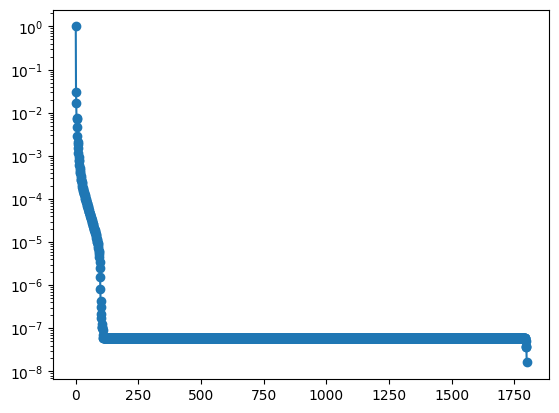

In [5]:

# Plotting singular values
pod = POD(len(p_train), problem, affine=False) # No affine decomposition is performed
pod.fit(u_train)
plot_singular_values(pod.singular_values)

In the case of `float32` data we can see that $125$ modes are required to capture the majority of the system’s energy.

Let's now fit a POD for several modes number and it compute the $L2$ error of the predictions:

In [6]:
pod_errors = []
pod_times = []
for n in n_modes:
    pod = POD(n, problem, affine=False)
    pod.fit(u_train)
    start = time.time()
    u_pred = pod.predict(p_test)
    pod_times.append(time.time() - start)
    pod_errors.append(compute_error(u_test, u_pred))

errors.append(pod_errors)
times.append(pod_times)
names.append("POD")

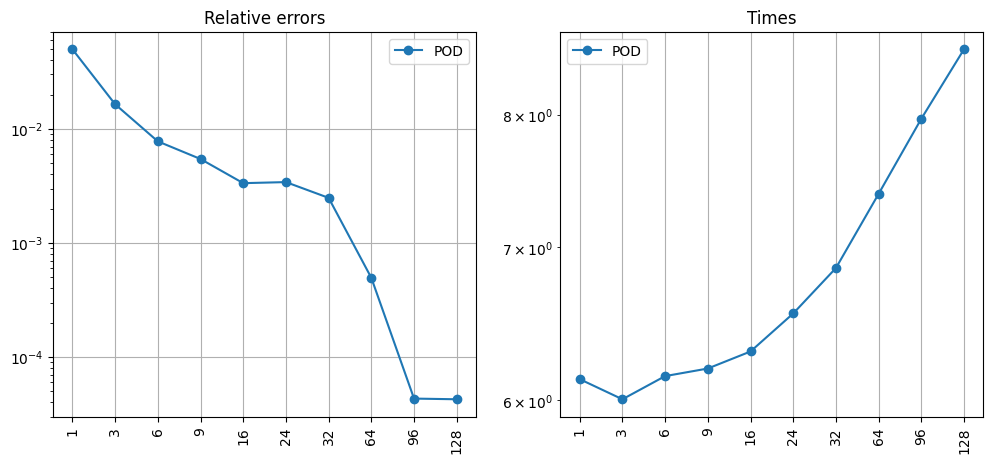

In [7]:
plot_errors_and_times(errors, times, names, n_modes)

Based in the previous plot, a proper number of modes for the POD is $128$. 

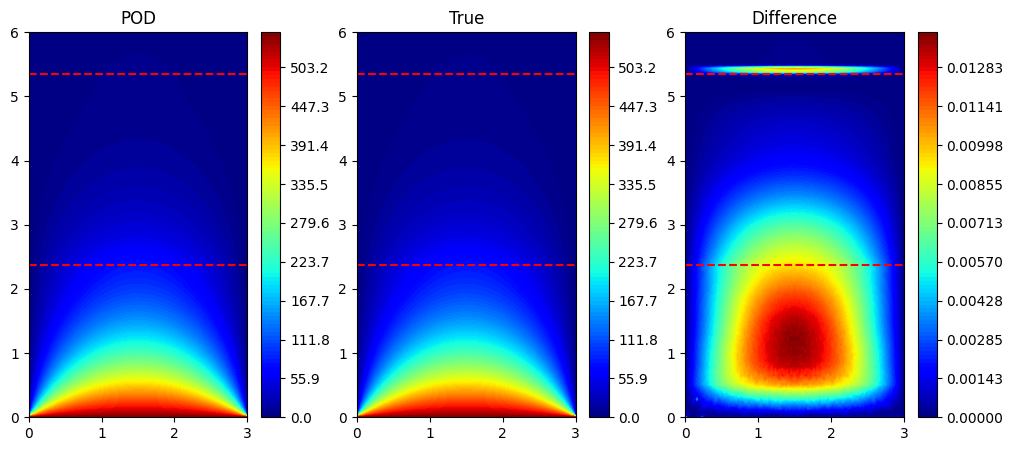

In [8]:
n = 96
pod = POD(n, problem, affine=False)
pod.fit(u_train)
u_pred = pod.predict(p_test)
plot_comparison(u_pred, u_test, pod.x, pod.y, p00, p01)

In [9]:
print(f"POD L2 error: {compute_error(u_test, u_pred):.4e}")

POD L2 error: 4.3205e-05


The performance in terms of predictive accuracy is certainly good. However, the computational time remains quite high, making POD ineffective at reducing overall computational complexity. Therefore, it is worthwhile to explore more advanced strategies based on deep learning architectures to speed up inference time.

# Machine learning approaches

In this section we will discuss the proposed architecture and the respective results focusing both on computational times and accuracy.

**IMPORTANT**: Since the training of the proposed architectures requires a huge amount of time, in this notebook I use already trained models. The models have been trained on a single RTX A4000 gpu using PINA library. The code for to perform the training is available in the repository https://github.com/FilippoOlivo/thermal-conduction-rom. Specifically, the script to train the model is `run.py` while the different model's configurations are available in the folder `experiments`

## Data preprocessing

Before training the model we decided to normalize the available data. For what it concerns the snapshot, we normalize them using the formula:

$$
\text{norm}(x) = \frac{x-\min}{\max - \min + 10^{-8}} \;\; \forall x \in S
$$
where $\min$ and $\max$ are respectively the minimum and the maximum values in the training snapshots and $S$ is the snapshot to normalize. The unormalization formula is given by:
$$
\text{unnorm}(S) = x \times (\max - \min + \epsilon) + \min \;\; \forall x \in S
$$

For what it concerns the parameters, we normalize them element wise:

$$
\text{normalize}(p_i) = \frac{p_i - \min_i}{\max_i - min_i + \epsilon} \;\; \forall p_i \in P
$$

where $\min_i = \min_j \left( P_{\text{train}}[j, i] \right)$ and $\max_i = \max_j \left( P_{\text{train}}[j, i] \right)$

In [10]:
data = np.load("data/data.npz") 
x,y = data["points"][:,0], data["points"][:,1]
snapshots = torch.tensor(data["simulations"], dtype=torch.float32)
parameters = torch.tensor(data["parameters"], dtype=torch.float32)
p_train, u_train, p_test, u_test = split_data(snapshots, parameters)

snap_normalizer = Normalizer(u_train)
params_normalizer = NormalizerParameters(p_train)
p_test = params_normalizer.normalize(p_test)
u_train = snap_normalizer.normalize(u_train)

# POD-NN

The first non-intrusive ROM tecnique used in this work is POD-NN. Similarly to POD-Galerkin, also this tecnique is composed by $2$ fundamental phases, the online and the offline. The main steps of the offline phase are:

1. Apply Singular Value Decomposition (SVD) to the snapshot matrix. This step yields three matrices:
  $$
  U \in \mathbb{R}^{N_{\text{dofs}} \times N_{\text{dofs}}},\quad
  \Sigma \in \mathbb{R}^{N_{\text{dofs}} \times N},\quad
  V \in \mathbb{R}^{N \times N}
  $$
  where $\Sigma$ is a diagonal matrix whose diagonal entries are the singular values.
2. Inspect the decay of the singular values to identify an "elbow" in the plot. This helps determine the number of modes needed to construct an accurate (and efficient) reduced basis.
3. Select $N_{\text{basis}}$, the number of basis vectors to retain, and construct the reduced basis by taking the first $N_{\text{basis}}$ columns of the matrix $U$.
4. Initialize and train Neural Network $\phi(\cdot)$ (usually a Multi Layer Perceptron) to predict the POD coefficients.

The Neural Network is trained in order to predict the POD coefficient such that mutiplied by the POD basis it returns an accurate prediction of the high fidelity solution. Meanwhile, the offline phase consist of the following steps:

1. Given a new set of parameters $\mathbf{\mu}$ Infer over the NN model $u_r = \phi(\mu)$
2. Project the coefficient on the high dimensional space $u = U \cdot u_r$

This strategy allows to overcome the fundamental issue in defining the affine decomposition in the test case considered in this work! 

In [11]:
def load_pod_nn(path, n):
    """
    Load POD-NN models from weigth file

    Args: 
        path (str): base path where the weights are saved.
        n (int): latent dimension
    """
    layers = [16, 64, 128]
    model = PODNN(pod_rank=n, layers= layers)
    model_path = os.path.join(base_path, f"{n:03d}/","model.pth")
    pod_path = os.path.join(base_path, f"{n:03d}/","pod_basis.pth")
    model.load_state_dict(torch.load(model_path))
    model.load_pod(pod_path)
    model.to('cpu')
    model.eval()
    return model

In [12]:
base_path = "models/pod_nn/"

pod_nn_errors = []
pod_nn_times = []
for i in n_modes:
    model = load_pod_nn(base_path, i)
    u_pred = torch.zeros(u_test.shape)
    start = time.time()
    with torch.no_grad():
        for i in range(len(u_test)):
            u_pred[i] = snap_normalizer.unnormalize(model(p_test[i:i+1]))
    pod_nn_times.append(time.time() - start)
    pod_nn_errors.append(compute_error(u_test, u_pred))

In [13]:
errors.append(pod_nn_errors)
times.append(pod_nn_times)
names.append("POD-NN")

The code below plots the results of POD compared with POD-NN. We can see that for a small number of modes, POD-NN achieves lower relative error than POD. After about 6 modes, the relative error of POD levels off around $5\times10^{-3}$. Meanwhile, the timing plot shows that POD-NN is approximately two orders of magnitude faster than POD-Galerkin.

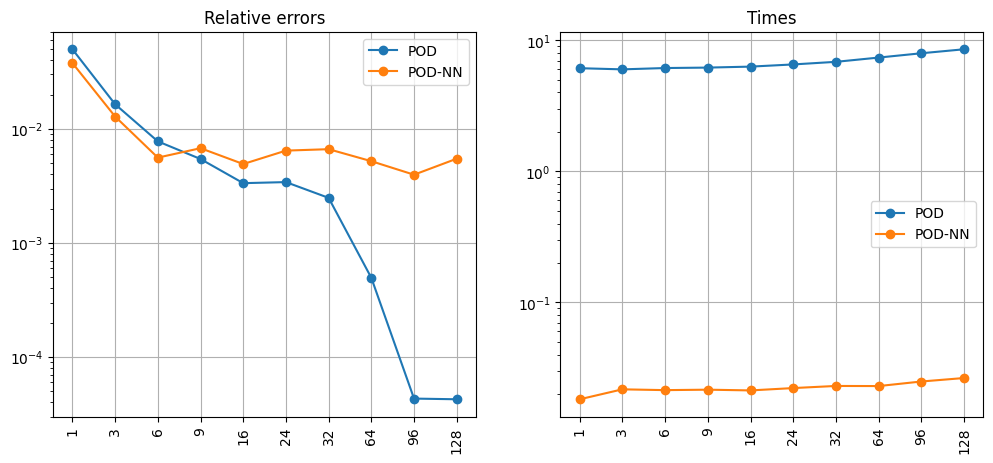

In [14]:
plot_errors_and_times(errors, times, names, n_modes)

POD-NN L2 error: 4.9161e-03


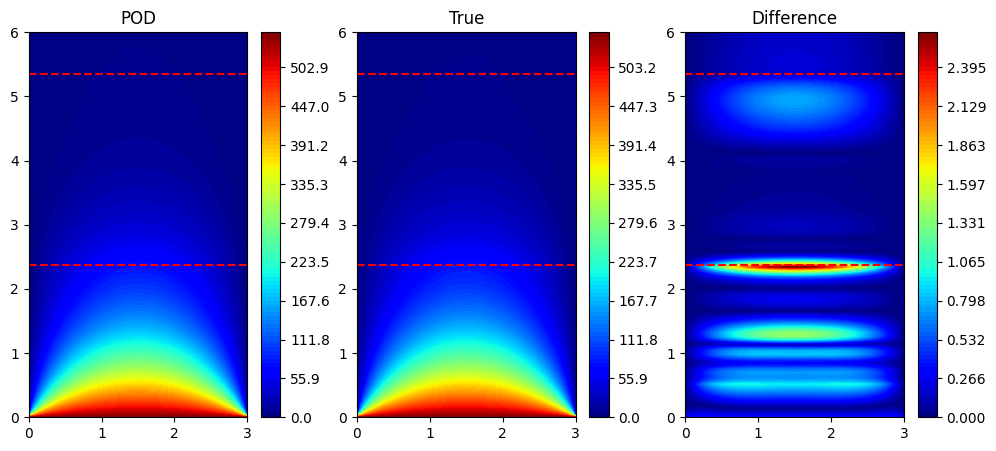

In [15]:
layers = [16, 64, 128]
base_path = "models/pod_nn/"
n = 16

model = PODNN(pod_rank=n, layers= layers)
model_path = os.path.join(base_path, f"{n:03d}/","model.pth")
pod_path = os.path.join(base_path, f"{n:03d}/","pod_basis.pth")
model.load_state_dict(torch.load(model_path))
model.load_pod(pod_path)
model.to('cpu')
model.eval()
u_pred = torch.zeros(u_test.shape)
with torch.no_grad():
    for i in range(200):
        u_pred[i] = snap_normalizer.unnormalize(model(p_test[i:i+1]))
plot_comparison(u_pred, u_test, x, y, p00, p01)
print(f"POD-NN L2 error: {compute_error(u_test, u_pred):.4e}")

As we can see from the plot, the error is mostly concentrated at the boundary between the first and second material. Moreover, in general, the error is much higher compared to that of standard POD.

# DL-ROM

The following technique we employ in this project is DL-ROM [1]. This architecture is essentially an autoencoder, a specific type of deep learning model trained to reduce the dimensionality of the input into a latent representation and then reconstruct the original input from that reduced representation. Specifically, DL-ROM consists of three components:

1. **Encoder**: Reduces the dimensionality of the input to obtain the latent representation.

2. **Decoder**: Reconstructs the high-dimensional input from the latent representation.
3. **Interpolation network**: Predicts the latent representation produced by the encoder, starting from the input parameters.

The figure below, taken from [1], graphically represents the structure of DL-ROM:

<div style="text-align: center;">
    <img src="img/dl_rom.png" alt="Domain" width="700px" />
</div>

The input to the autoencoder consists of the high-fidelity solutions, whose dimensionality is gradually reduced by successive convolutional layers, ending in a fully connected bottleneck composed of two fully connected layers. The decoder essentially reverses the reduction process performed by the encoder. Finally, the interpolation network takes as input the parameters of the PDE (in our case, the boundaries of the two regions and the bottom boundary temperature) and maps them to the latent representation, matching the one produced by the encoder. In the online phase only the interpolation network and the decoder are considered.

The test the performance in terms of relative error of the previosly described architecture varying the latent dimension:


In [16]:
def load_dl_rom(path, n):
    """
    Load DL-ROM models from weigth file

    Args: 
        path (str): base path where the weights are saved.
        n (int): latent dimension
    """
    input_dim = 16641
    in_channels = 1
    out_channels = 64
    hidden_channels = [4, 8, 16, 32]
    kernels = [5, 7, 7, 11, 11]
    strides = [1, 2, 2, 2, 2]
    bottleneck_hidden_dim = 256
    
    params_dim = 3 
    layers = [128, 256, 256, 256, 128]
    #Loading interpolation network
    reduction_net = DLROM(
        input_dim=input_dim,
        latent_dim=n,
        in_channels=in_channels,
        out_channels=out_channels,
        hidden_channels=hidden_channels,
        kernels=kernels,
        strides=strides,
        bottleneck_hidden_dim=bottleneck_hidden_dim
    )
    red_net_path = os.path.join(
        path, 
        f"{n:03d}/",
        "reduction_network.pth"
    )
    reduction_net.load_state_dict(torch.load(red_net_path))
    reduction_net.to('cpu').eval()

    # Loading reduction network
    interpolation_net = InterpolationNetwork(
        input_dim=params_dim,
        layers=layers, 
        latent_dim=n
    )
    int_net_path = os.path.join(
        path, 
        f"{n:03d}/",
        "interpolation_network.pth"
    )
    interpolation_net.load_state_dict(torch.load(int_net_path))
    interpolation_net.to('cpu').eval()
    return reduction_net, interpolation_net

In [17]:
base_path = "models/dl_rom/"
dl_rom_errors = []
dl_rom_times = []
for i in n_modes:
    reduction_net, interpolation_net = load_dl_rom(base_path, i)
    # Perform inference
    u_pred = torch.zeros(u_test.shape)
    start = time.time()
    with torch.no_grad():
        for i in range(200):
            tmp = interpolation_net(p_test[i:i+1])
            u_pred[i] = snap_normalizer.unnormalize(
                reduction_net.decode(tmp)
            )
    dl_rom_times.append(time.time() - start)
    dl_rom_errors.append(compute_error(u_test, u_pred))

In [18]:
errors.append(dl_rom_errors)
times.append(dl_rom_times)
names.append("DL-ROM")

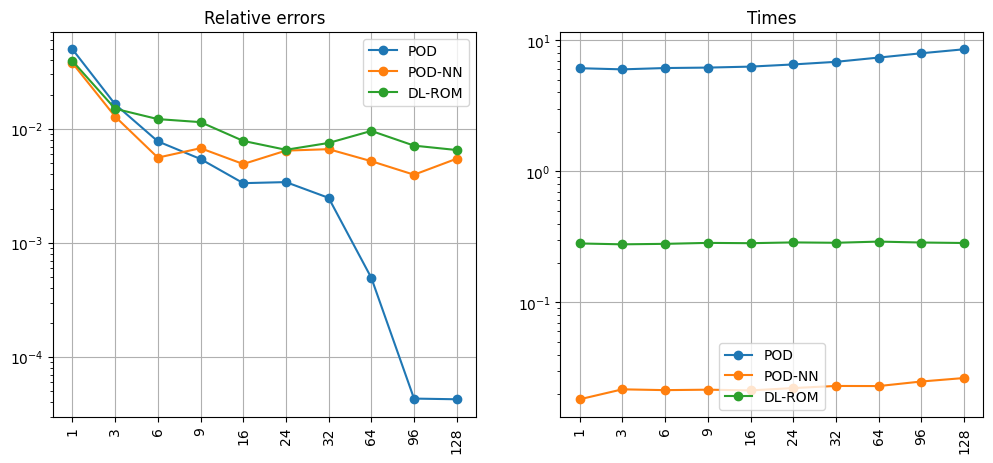

In [19]:
plot_errors_and_times(errors, times, names, n_modes)

From the plot above, we can conclude that the performance of the DL-ROM architecture is roughly comparable to that of POD-NN. However, the number of parameters in the two architectures differs significantly: the POD-NN model comprises around $10k$ parameters (excluding the reduced basis), while the DL-ROM model comprises around $2M$ parameters. From the time plot, we can can see that DL-ROM is bettween POD-Galerkin and POD-NN, computational times around $2$s to complete the prediction of $200$ simulations.

The following lines of code perform the reduction using the model with latent dimension equal to $24$ (the one that seems working the best on the plot above):

DL-ROM L2 error: 6.5535e-03


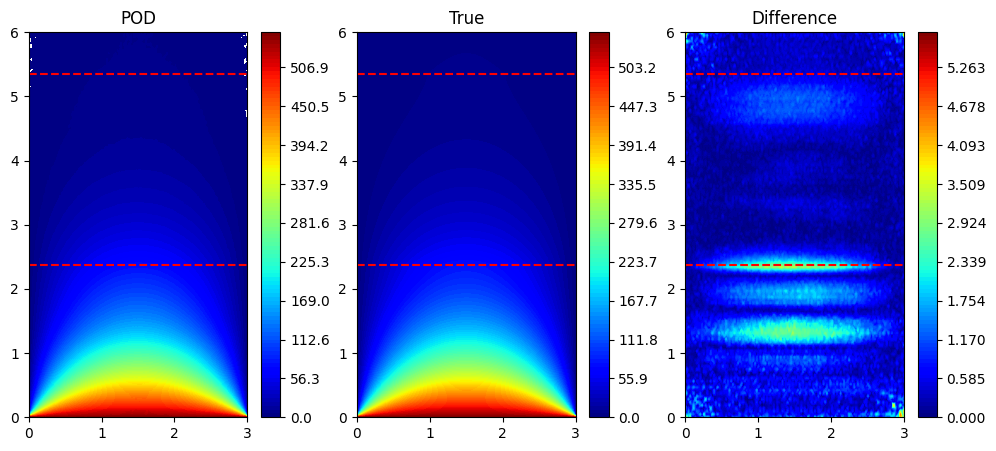

In [20]:
n = 24
reduction_net, interpolation_net = load_dl_rom(base_path, n)

# Perform inference
u_pred = torch.zeros(u_test.shape)
start = time.time()
with torch.no_grad():
    for i in range(200):
        tmp = interpolation_net(p_test[i:i+1])
        u_pred[i] = snap_normalizer.unnormalize(
            reduction_net.decode(tmp)
        )

plot_comparison(u_pred, u_test, x, y, p00, p01)
print(f"DL-ROM L2 error: {compute_error(u_test, u_pred):.4e}")

The plot above shows that most of the error is still at the boundary between the two materials. The total error is also similar in magnitude to that of POD-NN.

# POD-DL-ROM

In this section, I introduce another Deep Learning-based architecture that can be seen as an enhancement of the DL-ROM model. POD-DL-ROM [2] essentially consists of using an autoencoder architecture similar to the one presented in DL-ROM [1], but it operates on a reduced space obtained via POD projection. Specifically, the dimension of the input snapshots is reduced before being passed to the autoencoder by projecting them onto a basis composed of POD modes. The figure below, taken from [2], graphically represents the POD-DL-ROM approach:

<div style="text-align: center;">
    <img src="img/pod-dl-rom.png" alt="Domain" width="700px" />
</div>

In [21]:
def load_pod_dl_rom(path, n):
    """
    Load POD-DL-ROM models from weigth file

    Args: 
        path (str): base path where the weights are saved.
        n (int): latent dimension
    """
    in_channels = 1
    input_dim=16641
    out_channels = 64
    pod_modes=144
    hidden_channels = [8, 16, 32]
    kernels = [3, 3, 5, 5]
    strides = [1, 1, 2, 2]
    bottleneck_hidden_dim = 128
    
    params_dim = 3 
    layers = [128,128,128,128]

    #Loading interpolation network
    reduction_net = POD_DL_ROM(
        input_dim=input_dim,
        latent_dim=n,
        input_channels=in_channels,
        output_channels=out_channels,
        hidden_channels=hidden_channels,
        kernels=kernels,
        strides=strides,
        bottleneck_hidden_dim=bottleneck_hidden_dim,
        pod_modes=pod_modes
    )
    red_net_path = os.path.join(
        base_path, 
        f"{n:03d}/",
        "reduction_network.pth"
    )
    reduction_net.load_state_dict(torch.load(red_net_path))
    reduction_net.to('cpu').eval()

    # Loading reduction network
    interpolation_net = InterpolationNetwork(
        input_dim=params_dim,
        layers=layers, 
        latent_dim=n
    )
    int_net_path = os.path.join(
        base_path, 
        f"{n:03d}/",
        "interpolation_network.pth"
    )
    interpolation_net.load_state_dict(torch.load(int_net_path))
    interpolation_net.to('cpu').eval()

    return reduction_net, interpolation_net

In [22]:
base_path = "models/pod_dl_rom/"
pod_dl_rom_errors = []
pod_dl_rom_times = []

for i in n_modes:
    reduction_net, interpolation_net = load_pod_dl_rom(base_path, i)
    
    # Perform inference
    u_pred = torch.zeros(u_test.shape)
    with torch.no_grad():
        start = time.time()
        for i in range(200):
            tmp = interpolation_net(p_test[i:i+1])
            u_pred[i] = snap_normalizer.unnormalize(
                reduction_net.decode(tmp)
            )
    pod_dl_rom_times.append(time.time() - start)
    pod_dl_rom_errors.append(compute_error(u_test, u_pred))

In [23]:
errors.append(pod_dl_rom_errors)
times.append(pod_dl_rom_times)
names.append("POD-DL-ROM")

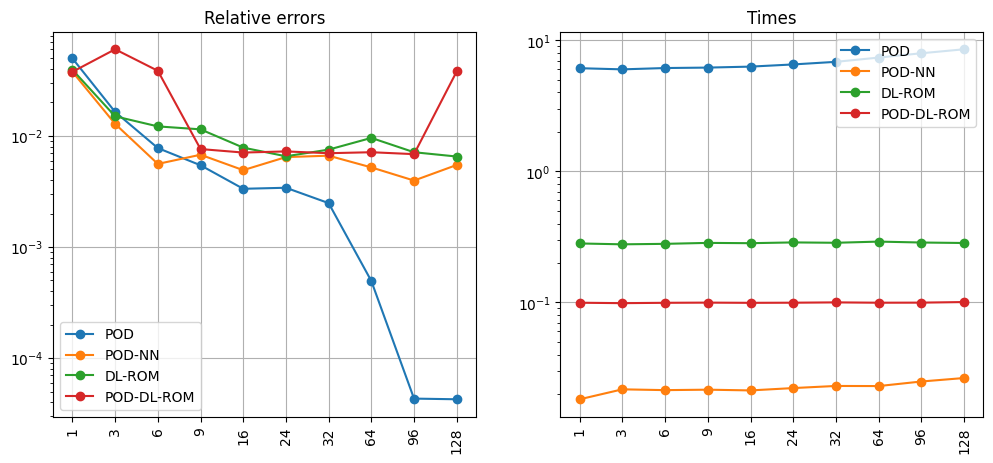

In [24]:
plot_errors_and_times(errors, times, names, n_modes)

The plot above shows that POD-DL-ROM has a more unstable behavior compared to the other DL-based models, particularly for $3$, $6$, and $128$ modes. For the other numbers of modes, the performance of POD-DL-ROM is comparable to that of the other two architectures. In terms of computational time, POD-DL-ROM lies between POD-NN and its predecessor, DL-ROM.

The following lines of code perform the predictions using the model with latent dimension equal to $9$:

POD-DL-ROM L2 error: 7.6126e-03


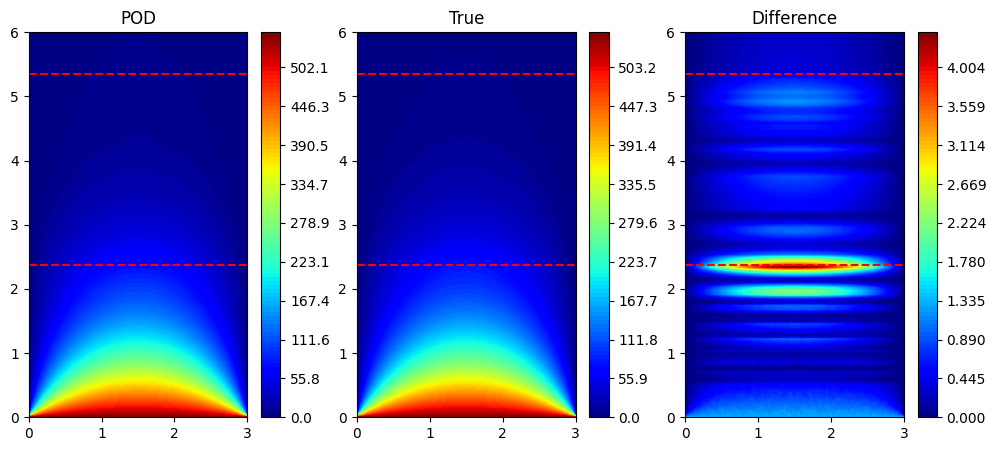

In [25]:
n = 9
reduction_net, interpolation_net = load_pod_dl_rom(base_path, n)

# Perform inference
u_pred = torch.zeros(u_test.shape)
start = time.time()
with torch.no_grad():
    for i in range(200):
        tmp = interpolation_net(p_test[i:i+1])
        u_pred[i] = snap_normalizer.unnormalize(
            reduction_net.decode(tmp)
        )

plot_comparison(u_pred, u_test, x, y, p00, p01)
print(f"POD-DL-ROM L2 error: {compute_error(u_test, u_pred):.4e}")

As expected, also in this case most of the error is concentrated in the boundary regions (especially the fist one).

# FNO

The last model presented in this work is a Neural Operator-based architecture [3], specifically the Fourier Neural Operator [4]. Neural Operators are specialized deep learning architectures designed to approximate mappings between function spaces. Typically, Neural Operators consist of three main components:

1. **Lifting network**: projects the input function into a higher-dimensional space, usually implemented as an MLP.
2. **Integral kernels**: capture spatial (or temporal) dependencies in the lifted space.
3. **Projection network**: maps the processed information back into the output function space.

In this work, we consider a specific type of Neural Operator called the Fourier Neural Operator, which implements the integral kernel using Fourier convolution. Specifically, the $i$-th integral layer is composed of two different branches:

1. It takes the output of the preceding layer, applies a Fourier transform, multiplies by a learnable filter in Fourier space, and then performs the inverse transform.
2. It applies a local linear transformation to the input data.

The outputs of these two branches are summed together, and the result is finally passed through a nonlinear activation function. The figure below graphically, taken from [4], represent the structure of the FNO:

<div style="text-align: center;">
    <img src="img/fno.png" alt="Domain" width="700px" />
</div>

Before using the Neural Operator model, we need to preprocess the input data. Since a Neural Operator is designed to learn mappings between functions, our input is transformed from a $1$D tensor with three components into a $3$D tensor with dimensions $H \times W \times C$, where $H$ and $W$ are both $129$ in our case, and the number of channels $C$ is set to $4$. Specifically, we have one channel for the $x$ coordinate, one for the $y$ coordinate, one channel representing the conductivities in the domain, and one channel representing the boundary temperature. The code to perform this preprocessing is available in the project repository in the file `no_preprocessing.py`. Before training, we apply a channel-wise normalization strategy.

Since training a FNO is computational expensive, we trained this model in a single parameter configuration, presented in the following lines of code.

In [26]:
data = np.load("data/data_no.npz") 
x,y = data["points"][:,0], data["points"][:,1]
snapshots = torch.tensor(data["simulations"], dtype=torch.float32)
parameters = torch.tensor(data["parameters"], dtype=torch.float32)
p_train, u_train, p_test, u_test = split_data(snapshots, parameters)

snap_normalizer = Normalizer(u_train)
params_normalizer = NormalizerParameters(p_train)
p_test = params_normalizer.normalize(p_test)
u_train = snap_normalizer.normalize(u_train)

FNO computational time: 1.557245e+00
POD-NN L2 error: 5.2510e-03


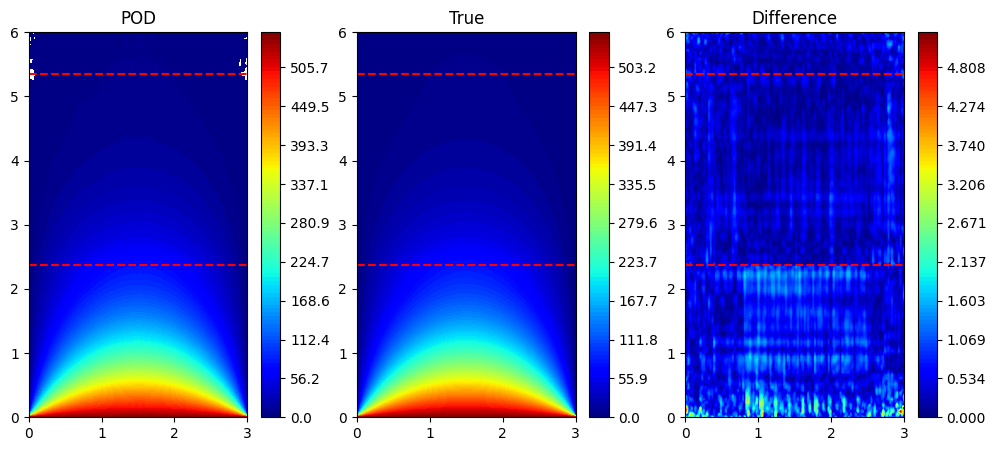

In [27]:
model = FNO2d(
    input_channels = 4,
    output_channels = 1,
    n_modes = 32,
    padding = 8,
    inner_size = 16,
    n_layers = 4,
)

path = "models/fno/032/model.pth"
model.load_state_dict(torch.load(path))
model.to("cpu").eval()
u_pred = torch.zeros(u_test.shape)
with torch.no_grad():
    start = time.time()
    for i in range(200):
        u_pred[i] = snap_normalizer.unnormalize(model(p_test[i:i+1]))
plot_comparison(u_pred, u_test, x, y, p00, p01)
print(f"FNO computational time: {(time.time() - start):4e}")
print(f"POD-NN L2 error: {compute_error(u_test, u_pred):.4e}")

The FNO model comprises approximately $2$M parameters, which is very similar to the number of parameters in the DL-ROM model. In terms of accuracy, it is able to make predictions with relative errors comparable to, and even slightly better than, those of the DL-ROM and POD-DL-ROM architectures. The computational times are also between those of the two mentioned architectures. Remarkably, with this last model, the error is not concentrated at the boundary between different materials.

# Conclusions

Based on the results presented in this notebook, we can conclude that none of the models considered achieves accuracy comparable to the standard POD-Galerkin approach. The best-performing method in the proposed scenario is POD-NN: thanks to its simplicity and versatility, this architecture is able to predict the solution very quickly, with a relative error around $5\times 10^{-3}$. In this problem, using more advanced and complex architectures such as DL-ROM, POD-DL-ROM or FNO does not provide any advantage in terms of accuracy, while introducing a non-negligible increase in computational complexity. This is probably due to the linear, but non-affine, nature of the problem.


# References 

[1] Stefania Fresca, Luca Dede’, and Andrea Manzoni, A Comprehensive Deep Learning-Based Approach to Reduced Order Modeling of Nonlinear Time-Dependent Parametrized PDEs. J Sci Comput 87, 61 (2021). https://doi.org/10.1007/s10915-021-01462-7

[2] Stefania Fresca, Andrea Manzoni,
POD-DL-ROM: Enhancing deep learning-based reduced order models for nonlinear parametrized PDEs by proper orthogonal decomposition. Computer Methods in Applied Mechanics and Engineering, (2022). https://doi.org/10.1016/j.cma.2021.114181.

[3] Nikola Kovachki, Zongyi Li, Burigede Liu,  Kamyar Azizzadenesheli, Kaushik Bhattacharya, Andrew Stuart, and Anima Anandkumar,  Neural operator: Learning maps between function spaces. Journal of Machine Learning Research, (2021). https://doi.org/10.48550/arXiv.2108.08481.

[4] Zongyi Li, Nikola Kovachki, Kamyar Azizzadenesheli, Burigede Liu, Kaushik Bhattacharya, Andrew Stuart, and Anima Anandkumar, (2020). Fourier neural operator for parametric partial differential equations. 
https://doi.org/10.48550/arXiv.2010.08895.